In [24]:
# stdlib
import datetime
import enum
import struct
import time

# util
from see import see

# rpi hardware
from RPi import GPIO as gpio
import smbus

# math or whatever
%matplotlib inline
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

# Refs

## SMBus/I<sup>2</sup>C

* https://www.kernel.org/doc/Documentation/i2c/smbus-protocol (`smbus` seems to wrap these fairly directly)
* http://raspberry-projects.com/pi/programming-in-python/i2c-programming-in-python/using-the-i2c-interface-2

## MCP9808

* https://cdn-shop.adafruit.com/datasheets/MCP9808.pdf

In [9]:
heater = 5
other = 6

gpio.setmode(gpio.BCM)  # corresponds to the pins listed on the perma-proto hat
gpio.setup(heater, gpio.OUT, initial=gpio.LOW)
# gpio.output(heater, gpio.HIGH)  # heater ON
# time.sleep(0.5)
# gpio.output(heater, gpio.LOW)  # heater OFF
# gpio.cleanup()  # reset pin state

def heater_on():
    gpio.output(heater, gpio.HIGH)  # heater ON
    
def heater_off():
    gpio.output(heater, gpio.LOW)  # heater OFF

In [2]:
smbus_device = 1
bus = smbus.SMBus(smbus_device)

In [3]:
def byte_flip(word):
    return int.from_bytes((word).to_bytes(2, "little"), "big")


def byte_flip2(word):
    msb, lsb = divmod(word, 256)
    return lsb * 256 + msb


for n in range(2**15):
    assert byte_flip(n) == byte_flip2(n)
    

class MCP9808:
    class Registers(enum.IntEnum):
        CONFIG = 0b0001
        T_UPPER = 0b0010
        T_LOWER = 0b0011
        T_CRIT = 0b0100
        TEMP = 0b0101
        MFC_ID = 0b0110
        DEV_ID = 0b0111
        RESOLUTION = 0b1000
        
    class Resolution(enum.IntEnum):
        C_2 = 0b00  # t_CONV = 30 ms typ
        C_4 = 0b01  # t_CONV = 60 ms typ
        C_8 = 0b10  # t_CONV = 130 ms typ
        C_16 = 0b11  # t_CONV = 250 ms typ, DEFAULT
        
    class Flags(enum.IntFlag):
        T_CRITICAL = 0x8000
        T_HIGH = 0x4000
        T_LOW = 0x2000
        
    BASE_ADDRESS = 0x18
    
    # second byte is LSB on the datasheet, but smbus reads it as MSB. these values
    # are byte-flipped to match what smbus will give.
    MFC_ID = 0b0000_0000_0101_0100
    DEV_ID = 0b0000_0100_0000_0000
        
    def __init__(self, smbus, address_bits=0b000):
        self.smbus = smbus
        self.address = self.BASE_ADDRESS + address_bits
        
        self._validate()
        
    def _read_word(self, register):
        word = self.smbus.read_word_data(self.address, register)
        return byte_flip(word)
        
    def _validate(self):
        mfc_word = self._read_word(self.Registers.MFC_ID)
        if mfc_word != self.MFC_ID:
            raise RuntimeError(f"manufacturer ID does not match! (received {mfc_word})")
        
        dev_word = self._read_word(self.Registers.DEV_ID)
        if dev_word != self.DEV_ID:
            raise RuntimeError(f"device ID/revision does not match! (received {dev_word})")
        
    def _read_temp(self):
        word = self._read_word(self.Registers.TEMP)
        flags = self.Flags(word & 0xE000)
        
        if word & 0x1000:
            word = word & 0x0FFF
            return flags, (word / 16) - 256

        return flags, (word & 0x1FFF) / 16
        
    @property
    def T(self):
        _flags, temp = self._read_temp()
        return temp
    
    @property
    def resolution(self):
        res = self.smbus.read_byte_data(self.address, self.Registers.RESOLUTION)
        return self.Resolution(res)
    
    @resolution.setter
    def resolution(self, value):
        self.smbus.write_byte_data(self.address, self.Registers.RESOLUTION, value)

In [4]:
mcp9808 = MCP9808(bus, 0b000)

In [10]:
mcp9808.resolution = mcp9808.Resolution.C_8

# Time Points

In [21]:
period = 0.25
points = []

for n in range(20):
    sync = period - time.time() % period
    time.sleep(sync)
    now = time.time()
    points.append({
        "t": now,
        "temp": mcp9808.T,
    })

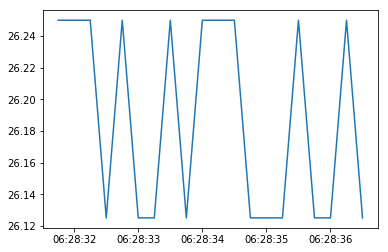

In [25]:
f, ax = plt.subplots()
times, temps = zip(*((p["t"], p["temp"]) for p in points))
times = [datetime.datetime.fromtimestamp(t) for t in times]
ax.plot(times, temps)

# Heat Pulse(s)

In [49]:
period = 0.25
points = []
events = []

def collect_points(n):
    print(f"collecting data for {n * 0.25} sec")
    for _ in range(n):
        sync = period - time.time() % period
        time.sleep(sync)
        now = time.time()
        points.append({
            "t": now,
            "temp": mcp9808.T,
        })

def hoff():
    heater_off()
    events.append({"t": time.time(), "event": "off"})
    print("heater off")
        
def hon():
    heater_on()
    events.append({"t": time.time(), "event": "on"})
    print("heater on")

collect_points(100)
hon()
collect_points(200)
hoff()
collect_points(200)
hon()
collect_points(200)
hoff()
collect_points(200)
hon()
collect_points(200)
hoff()
collect_points(1000)
hon()
collect_points(1000)
hoff()
collect_points(1000)

collecting data for 25.0 sec
heater on
collecting data for 50.0 sec
heater off
collecting data for 50.0 sec
heater on
collecting data for 50.0 sec
heater off
collecting data for 50.0 sec
heater on
collecting data for 50.0 sec
heater off
collecting data for 250.0 sec
heater on
collecting data for 250.0 sec
heater off
collecting data for 250.0 sec


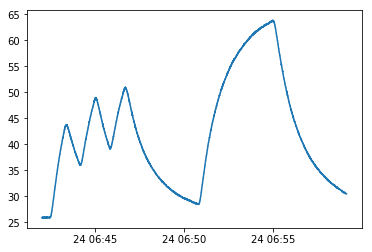

In [50]:
f, ax = plt.subplots()
times, temps = zip(*((p["t"], p["temp"]) for p in points))
times = [datetime.datetime.fromtimestamp(t) for t in times]
ax.plot(times, temps)

In [46]:
mcp9808.T

27.5

# Controlling

Most basic closed-loop method possible.

In [56]:
switch_period = 5
n_points_per_period = int(switch_period / period)
points = []
events = []

target = 40

for _ in range(150):
    collect_points(n_points_per_period)
    print(points[-1]["temp"])
    if points[-1]["temp"] < target:
        hon()
    else:
        hoff()

collecting data for 5.0 sec
31.375
heater on
collecting data for 5.0 sec
31.875
heater on
collecting data for 5.0 sec
33.375
heater on
collecting data for 5.0 sec
35.625
heater on
collecting data for 5.0 sec
37.625
heater on
collecting data for 5.0 sec
39.75
heater on
collecting data for 5.0 sec
41.625
heater off
collecting data for 5.0 sec
43.0
heater off
collecting data for 5.0 sec
43.125
heater off
collecting data for 5.0 sec
42.625
heater off
collecting data for 5.0 sec
42.0
heater off
collecting data for 5.0 sec
41.25
heater off
collecting data for 5.0 sec
40.5
heater off
collecting data for 5.0 sec
39.875
heater on
collecting data for 5.0 sec
39.625
heater on
collecting data for 5.0 sec
40.625
heater off
collecting data for 5.0 sec
41.875
heater off
collecting data for 5.0 sec
42.125
heater off
collecting data for 5.0 sec
41.5
heater off
collecting data for 5.0 sec
41.0
heater off
collecting data for 5.0 sec
40.375
heater off
collecting data for 5.0 sec
39.75
heater on
collecting

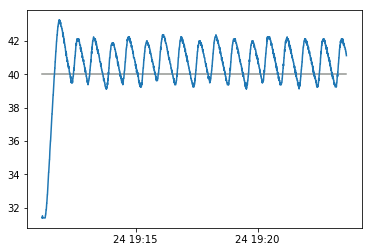

In [61]:
f, ax = plt.subplots()
times, temps = zip(*((p["t"], p["temp"]) for p in points))
times = [datetime.datetime.fromtimestamp(t) for t in times]
ax.plot([times[0], times[-1]], [target, target], color="xkcd:grey")
ax.plot(times, temps)